<a href="https://colab.research.google.com/github/abharanirocks/Assignment_Timecard/blob/main/Assignment_Timecard.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

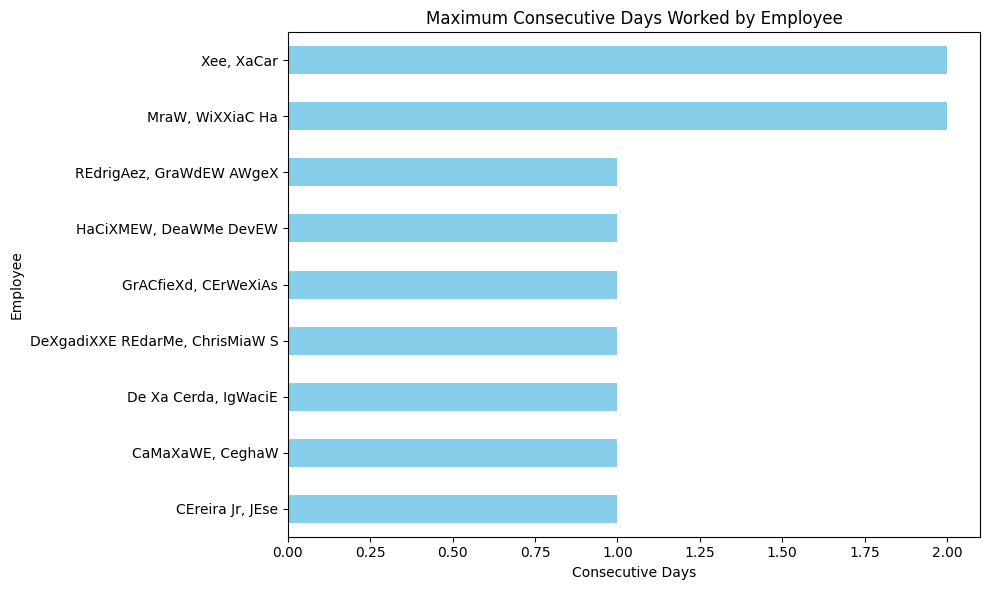

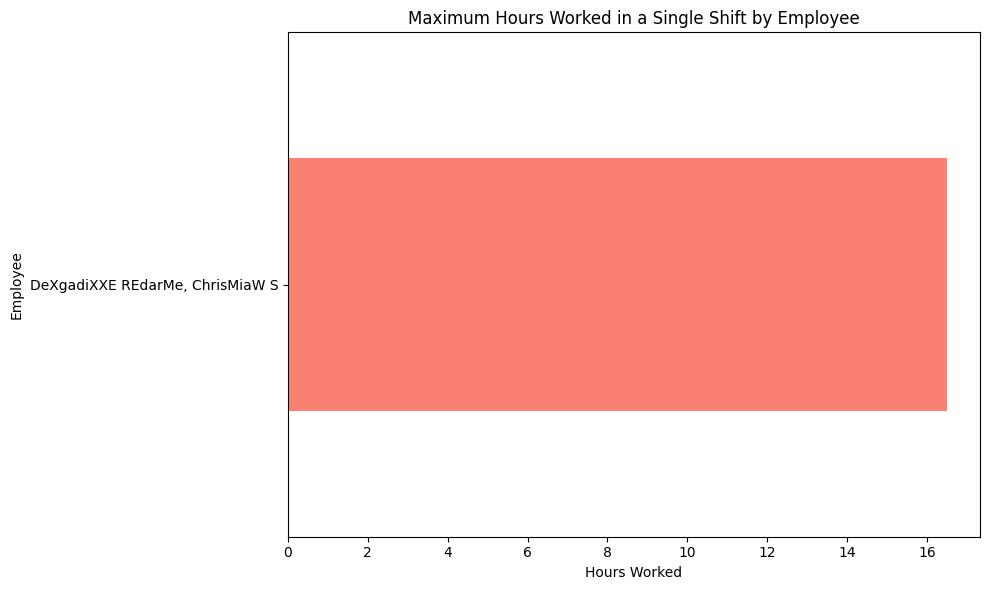

In [4]:
import pandas as pd
from datetime import timedelta
import matplotlib.pyplot as plt

def preprocess_timecard_hours(value):
    """
    Preprocess the timecard hours value.

    Args:
    value (str): Value of the timecard hours.

    Returns:
    timedelta: Time duration as timedelta object.
    """
    if pd.isna(value):
        return timedelta(seconds=0)

    parts = value.split(':')
    hours = int(parts[0])
    minutes = int(parts[1])

    return timedelta(hours=hours, minutes=minutes)

def clean_timecard_data(df):
    """
    Clean the timecard data DataFrame.

    Args:
    df (DataFrame): DataFrame containing timecard data.

    Returns:
    DataFrame: Cleaned DataFrame.
    """
    # Drop unnecessary columns
    df = df.drop(columns=['Unnamed: 9', 'Unnamed: 10'])

    # Rename columns for standardization
    df.columns = ['Position ID', 'Position Status', 'Time', 'Time Out', 'Timecard Hours', 'Pay Cycle Start Date', 'Pay Cycle End Date', 'Employee Name', 'File Number']

    # Convert date and time columns to datetime objects
    df['Time'] = pd.to_datetime(df['Time'])
    df['Time Out'] = pd.to_datetime(df['Time Out'])
    df['Pay Cycle Start Date'] = pd.to_datetime(df['Pay Cycle Start Date'])
    df['Pay Cycle End Date'] = pd.to_datetime(df['Pay Cycle End Date'])

    # Preprocess the 'Timecard Hours' column
    df['Timecard Hours'] = df['Timecard Hours'].apply(preprocess_timecard_hours)

    return df

def analyze_timecard_data(file_path):
    """
    Analyzes the timecard data from the given Excel file.

    Args:
    file_path (str): Path to the Excel file containing timecard data.

    Returns:
    tuple: A tuple containing three lists - consecutive_days_data, excessive_hours_data, and report_rows.
    """
    consecutive_days_data = []
    excessive_hours_data = []
    report_rows = []

    try:
        # Read Excel file
        df = pd.read_excel(file_path, engine='openpyxl')

        # Clean the data
        df = clean_timecard_data(df)

        # Group data by employee name
        grouped = df.groupby('Employee Name')

        for name, group in grouped:
            consecutive_days = 1
            prev_time_out = None
            consecutive_days_warning = False
            excessive_hours_warning = False

            for index, row in group.iterrows():
                if prev_time_out is not None and row['Time'].date() == (prev_time_out + timedelta(days=1)).date():
                    consecutive_days += 1
                else:
                    consecutive_days = 1

                if prev_time_out is not None and (row['Time'] - prev_time_out) < timedelta(hours=10) and (row['Time'] - prev_time_out) > timedelta(hours=1):
                    consecutive_days_data.append({'Employee': name, 'Position': row['Position ID'], 'Date': row['Time'].date(), 'Consecutive Days': consecutive_days})
                    consecutive_days_warning = True

                if row['Timecard Hours'] > timedelta(hours=14):
                    excessive_hours_data.append({'Employee': name, 'Position': row['Position ID'], 'Date': row['Time'].date(), 'Hours Worked': row['Timecard Hours']})
                    excessive_hours_warning = True

                prev_time_out = row['Time Out']

                if consecutive_days == 7:
                    start_date = row['Time'] - timedelta(days=6)
                    report_rows.append({'Employee': name, 'Position': row['Position ID'], 'Start Date': start_date.date(), 'End Date': row['Time'].date(), 'Consecutive Days': 7})
                    break

            if consecutive_days_warning or excessive_hours_warning:
                report_rows.append({'Employee': name, 'Consecutive Days Warning': consecutive_days_warning, 'Excessive Hours Warning': excessive_hours_warning})

    except FileNotFoundError:
        print("Error: File not found.")
    except Exception as e:
        print("Error:", e)

    return consecutive_days_data, excessive_hours_data, report_rows

def print_report_to_file(report_rows,consecutive_days_data, excessive_hours_data, file_path):
    """
    Prints the timecard analysis report to a text file.

    Args:
    report_rows (list): List of dictionaries containing report data.
    consecutive_days_data (list): List of dictionaries containing consecutive days data.
    excessive_hours_data (list): List of dictionaries containing excessive hours data.
    file_path (str): Path to the text file.

    Returns:
    None
    """
    if not report_rows:
        with open(file_path, 'w') as file:
            file.write("No issues found.")
        return

    with open(file_path, 'w') as file:
        file.write("\n------------- Timecard Analysis Report -------------\n")
        report_df = pd.DataFrame(report_rows)
        if not report_df.empty:
            report_df = report_df.fillna('N/A')
            file.write(report_df.to_string(index=False))
        # a) Who has worked for 7 consecutive days
        if consecutive_days_data:
            consecutive_days_df = pd.DataFrame(consecutive_days_data)
            consecutive_days_employees = consecutive_days_df['Employee'].unique()
            file.write("\na) Employees who have worked for 7 consecutive days:\n")
            for employee in consecutive_days_employees:
                file.write(f"- {employee}\n")

        # b) Who have less than 10 hours of time between shifts but greater than 1 hour
        if report_df['Consecutive Days Warning'].any():
            less_than_10_hours_employees = report_df.loc[report_df['Consecutive Days Warning'] == True, 'Employee'].unique()
            file.write("\nb) Employees who have less than 10 hours between shifts but greater than 1 hour:\n")
            for employee in less_than_10_hours_employees:
                file.write(f"- {employee}\n")

        # c) Who has worked for more than 14 hours in a single shift
        if excessive_hours_data:
            excessive_hours_df = pd.DataFrame(excessive_hours_data)
            excessive_hours_employees = excessive_hours_df['Employee'].unique()
            file.write("\nc) Employees who have worked for more than 14 hours in a single shift:\n")
            for employee in excessive_hours_employees:
                file.write(f"- {employee}\n")

        file.write("\n")
        file.write("\n")

def generate_charts(consecutive_days_data, excessive_hours_data, chart_height=6, chart_width=10, save_path=None):
    """
    Generates charts based on consecutive days and excessive hours data.

    Args:
    consecutive_days_data (list): List of dictionaries containing consecutive days data.
    excessive_hours_data (list): List of dictionaries containing excessive hours data.
    chart_height (int): Height of the charts.
    chart_width (int): Width of the charts.
    save_path (str): Path to save the generated charts. If None, charts will be displayed but not saved.

    Returns:
    None
    """
    if consecutive_days_data:
        consecutive_days_df = pd.DataFrame(consecutive_days_data)
        plt.figure(figsize=(chart_width, chart_height))
        consecutive_days_chart = consecutive_days_df.groupby('Employee')['Consecutive Days'].max().sort_values().plot(kind='barh', color='skyblue')
        plt.title('Maximum Consecutive Days Worked by Employee')
        plt.xlabel('Consecutive Days')
        plt.ylabel('Employee')
        plt.tight_layout()
        if save_path:
            plt.savefig(save_path + "_consecutive_days_chart.png")
        else:
            plt.show()

    if excessive_hours_data:
        excessive_hours_df = pd.DataFrame(excessive_hours_data)
        plt.figure(figsize=(chart_width, chart_height))
        excessive_hours_df['Hours Worked'] = excessive_hours_df['Hours Worked'].apply(lambda x: x.total_seconds() / 3600)
        excessive_hours_chart = excessive_hours_df.groupby('Employee')['Hours Worked'].max().sort_values().plot(kind='barh', color='salmon')
        plt.title('Maximum Hours Worked in a Single Shift by Employee')
        plt.xlabel('Hours Worked')
        plt.ylabel('Employee')
        plt.tight_layout()
        if save_path:
            plt.savefig(save_path + "_excessive_hours_chart.png")
        else:
            plt.show()

def main(file_path, output_path):
    consecutive_days_data, excessive_hours_data, report_rows = analyze_timecard_data(file_path)
    print_report_to_file(report_rows, consecutive_days_data, excessive_hours_data, output_path + "_report.txt")
    generate_charts(consecutive_days_data, excessive_hours_data, save_path=output_path)

# Test the function with the given Excel file
file_path = "/content/drive/MyDrive/colab/Assignment_Timecard.xlsx"
output_path = "/content/drive/MyDrive/colab/Timecard_Analysis_Output"
main(file_path, output_path)
